<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/ClusterC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yellowbrick

#Introdução ao Projeto de Análise de Clusters

### Neste projeto, vamos realizar uma análise de clusters para segmentar nossos dados utilizando diferentes algoritmos de clustering, como K-Means e Gaussian Mixture Model (GMM). Nosso objetivo é identificar grupos distintos dentro dos dados com características similares, facilitando a criação de estratégias mais direcionadas e eficientes.

###Análise Exploratória:

Normalização e preparação dos dados para garantir que todas as características estejam na mesma escala.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from pyspark.sql.types import FloatType
from ipywidgets import interact, IntSlider
import plotly.express as px
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, silhouette_score

spark = SparkSession.builder.appName("ClusterCompras").getOrCreate()

df = spark.read.csv("online.csv", header=True, inferSchema=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371           |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233 |29011.161534536903|21848.

In [3]:
# Preencher valores nulos na coluna Description
df = df.fillna({'Description': 'No description'})

df = df.filter(col("Customer ID").isNotNull())


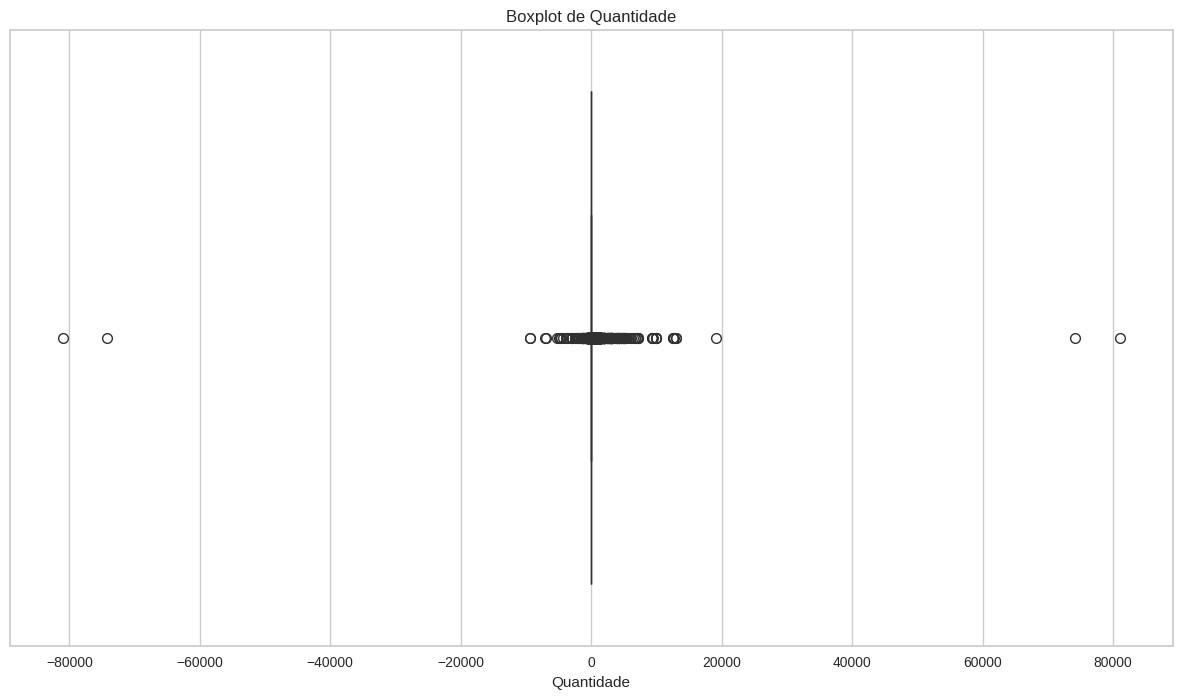

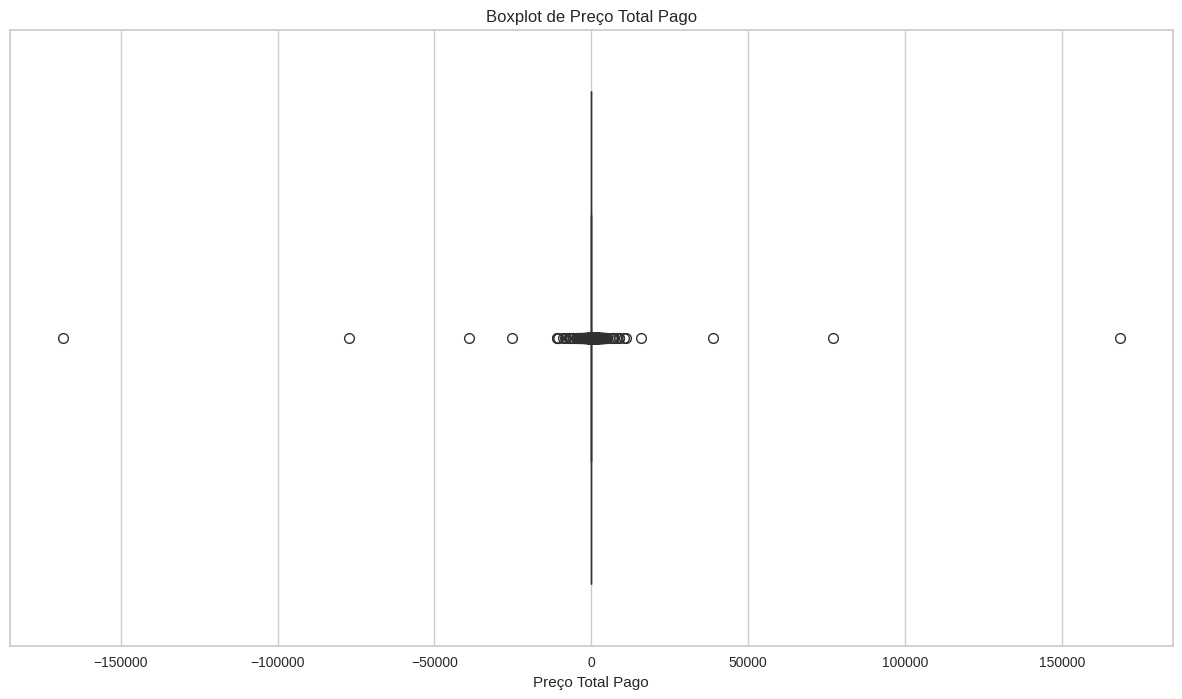

In [4]:
# os dados estão concentrados próximos a média vamos explorar os outliers
df = df.withColumn("TotalPrice", col("Quantity") * col("Price"))
quantity_pd = df.select("Quantity").toPandas()
price_pd = df.select("Price").toPandas()
total_price_pd = df.select("TotalPrice").toPandas()

# Boxplot de Quantidade
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_pd["Quantity"])
plt.title("Boxplot de Quantidade")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço Total Pago
plt.figure(figsize=(15, 8))
sns.boxplot(x=total_price_pd["TotalPrice"])
plt.title("Boxplot de Preço Total Pago")
plt.xlabel("Preço Total Pago")
plt.show()

In [5]:
# Os outliears são principalmente provenientes de extornos e de compras anteriores ao período considerado, podemos E L I M I N A L O S para essa análisae

quantity_greater_20000 = df.filter(col("Quantity") > 10000).count()
quantity_less_20000 = df.filter(col("Quantity") < -10000).count()
price_greater_20000 = df.filter(col("TotalPrice") > 15000).count()
price_less_20000 = df.filter(col("TotalPrice") < -15000).count()

print("Quantidade de valores em Quantity > 20000:", quantity_greater_20000)
print("Quantidade de valores em Quantity < -20000:", quantity_less_20000)
print("Quantidade de valores em Price > 20000:", price_greater_20000)
print("Quantidade de valores em Price < -20000:", price_less_20000)

df = df.filter((col("Quantity") <= 15000) & (col("Quantity") >= -15000))

df = df.filter((col("TotalPrice") <= 12000) & (col("TotalPrice") >= -12000))

Quantidade de valores em Quantity > 20000: 8
Quantidade de valores em Quantity < -20000: 2
Quantidade de valores em Price > 20000: 4
Quantidade de valores em Price < -20000: 4


In [6]:
df.describe().show(truncate=False)

+-------+-----------------+------------------+-----------------------------------+------------------+-----------------+------------------+-----------+-----------------+
|summary|Invoice          |StockCode         |Description                        |Quantity          |Price            |Customer ID       |Country    |TotalPrice       |
+-------+-----------------+------------------+-----------------------------------+------------------+-----------------+------------------+-----------+-----------------+
|count  |824355           |824355            |824355                             |824355            |824355           |824355            |824355     |824355           |
|mean   |537410.8595408477|28826.605696464347|NULL                               |12.380052283300277|3.598307268100174|15324.6421468906  |NULL       |20.20448699651045|
|stddev |26666.38803325448|18528.759904059953|NULL                               |76.7017532814157  |48.23691349302753|1697.4640858554735|NULL       |84.95

In [7]:
df.groupBy(year("InvoiceDate").alias("Ano")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy(month("InvoiceDate").alias("Mês")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()


df.groupBy(dayofmonth("InvoiceDate").alias("Dia")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy("Country") \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy("StockCode", "Description").agg(sum("Quantity").alias("TotalQuantity"), sum("Price").alias("TotalPrice")).orderBy("TotalQuantity", ascending=False).show()

df.groupBy("Customer ID").agg(countDistinct("Invoice").alias("TotalOrders"), sum("Price").alias("TotalSpent")).orderBy("TotalSpent", ascending=False).show()

correlation = df.select("Quantity", "TotalPrice").corr("Quantity", "TotalPrice")
print("Correlação entre Quantity e TotalPrice:", correlation)

+----+-----------+------------------+------------------+
| Ano|TotalOrders|        TotalSpent|         AvgTicket|
+----+-----------+------------------+------------------+
|2010|      22493|1577602.2539999525| 70.13747628150769|
|2011|      20476|1282155.0339999865| 62.61745624145275|
|2009|       1900|106525.29999999968|56.065947368420886|
+----+-----------+------------------+------------------+

+---+-----------+------------------+------------------+
|Mês|TotalOrders|        TotalSpent|         AvgTicket|
+---+-----------+------------------+------------------+
| 11|       6231| 386634.1320000023|62.050093403948374|
| 10|       4849| 398591.8300000037| 82.20083109919646|
| 12|       4527|289690.93000000133| 63.99181135409793|
|  9|       4119| 268758.0729999997| 65.24837897547941|
|  5|       3617|224625.57000000094| 62.10272878075779|
|  6|       3537|209702.27000000057| 59.28817359344093|
|  3|       3526| 279015.4210000013| 79.13086245036907|
|  7|       3306|198153.29100000032|59.9

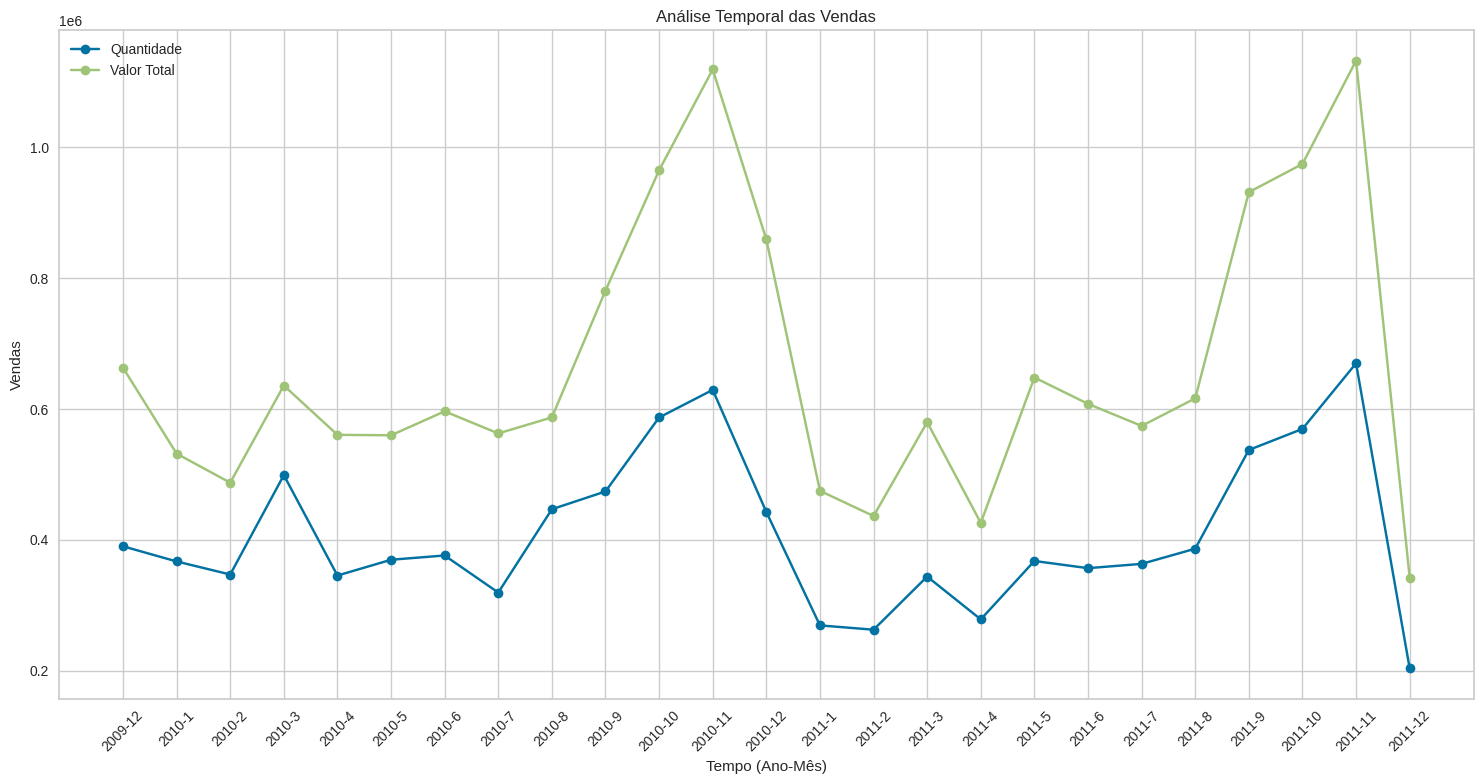

In [8]:
temporal_df = df.withColumn("Year", year("InvoiceDate")).withColumn("Month", month("InvoiceDate"))
temporal_agg_df = temporal_df.groupBy("Year", "Month").agg(sum("Quantity").alias("TotalQuantity"), sum(expr("Quantity * Price")).alias("TotalValue")).orderBy("Year", "Month")
temporal_agg_pd = temporal_agg_df.toPandas()

plt.figure(figsize=(15, 8))

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalQuantity"], label="Quantidade", marker='o')

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalValue"], label="Valor Total", marker='o')

plt.title("Análise Temporal das Vendas")
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Vendas")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# quem compra PINK REGENCY TEACUP AND SAUCER e ROSES REGENCY TEACUP AND SAUCER também compra GREEN REGENCY TEACUP AND SAUCER
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))
# Adicionar colunas de data
df = df.withColumn("DayOfWeek", dayofweek("InvoiceDate"))
df = df.withColumn("HourOfDay", hour("InvoiceDate"))

# Calcular RFM
recency_df = df.groupBy("Customer ID").agg(datediff(current_date(), max("InvoiceDate")).alias("Recency"))
frequency_df = df.groupBy("Customer ID").agg(count("Invoice").alias("Frequency"))
monetary_df = df.groupBy("Customer ID").agg(sum("TotalPrice").alias("Monetary"))

rfm_df = recency_df.join(frequency_df, "Customer ID").join(monetary_df, "Customer ID")

avg_spent_per_purchase_df = df.groupBy("Customer ID").agg((sum("TotalPrice") / countDistinct("Invoice")).alias("AvgSpentPerPurchase"))
variety_of_products_df = df.groupBy("Customer ID").agg(countDistinct("StockCode").alias("VarietyOfProducts"))

feature_df = rfm_df.join(avg_spent_per_purchase_df, "Customer ID").join(variety_of_products_df, "Customer ID")

feature_df = feature_df.orderBy(col("Monetary").desc())

feature_df.show()

# Análise de Cohorts
cohort_df = df.groupBy("Customer ID").agg(min("InvoiceDate").alias("CohortDate"))
cohort_df = cohort_df.withColumn("CohortYear", year("CohortDate")).withColumn("CohortMonth", month("CohortDate"))

cohort_df.show()

basket_data = df.groupBy("Invoice").agg(collect_set("StockCode").alias("Items"))
from pyspark.ml.fpm import FPGrowth
# Aplicar algoritmo FPGrowth
fpgrowth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.01)
model = fpgrowth.fit(basket_data)

model.freqItemsets.orderBy(col("freq").desc()).show(truncate=False)

model.associationRules.orderBy(col("confidence").desc()).show(truncate=False)


+-----------+-------+---------+------------------+-------------------+-----------------+
|Customer ID|Recency|Frequency|          Monetary|AvgSpentPerPurchase|VarietyOfProducts|
+-----------+-------+---------+------------------+-------------------+-----------------+
|    18102.0|   4765|     1068| 598215.2200000001|  3909.903398692811|              384|
|    14646.0|   4766|     3890| 523342.0700000004|  3191.110182926829|              964|
|    14156.0|   4774|     4130|296564.69000000024| 1468.1420297029704|             1446|
|    14911.0|   4766|    11613|  270248.529999999|  529.8990784313722|             2557|
|    17450.0|   4773|      448|233579.39000000013| 3829.1703278688524|              148|
|    13694.0|   4768|     1558|190825.52000000016| 1163.5702439024394|              902|
|    17511.0|   4767|     2134| 171885.9799999999| 2022.1879999999999|              678|
|    12415.0|   4789|      990|143269.28999999986|  4341.493636363635|              498|
|    16684.0|   4769|

In [10]:
feature_df = feature_df.filter(col("Monetary") >= 0)
quantile_99 = feature_df.approxQuantile("Monetary", [0.96], 0.01)[0]
filtered_df = feature_df.filter(feature_df.Monetary < quantile_99)

assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary", "AvgSpentPerPurchase", "VarietyOfProducts"], outputCol="temp_features")
temp_features = assembler.transform(filtered_df)

# Normalizar as características
scaler = StandardScaler(inputCol="temp_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(temp_features)
scaled_data = scaler_model.transform(temp_features)

# Função para extrair elementos do vetor
def extract_element(v, i):
    try:
        return float(v[i])
    except IndexError:
        return None

extract_element_udf = udf(extract_element, FloatType())

# Aplicar a UDF para criar colunas separadas
scaled_data = scaled_data.withColumn("scaledRecency", extract_element_udf(col("scaled_features"), lit(0))) \
                         .withColumn("scaledFrequency", extract_element_udf(col("scaled_features"), lit(1))) \
                         .withColumn("scaledMonetary", extract_element_udf(col("scaled_features"), lit(2))) \
                         .withColumn("scaledAvgSpentPerPurchase", extract_element_udf(col("scaled_features"), lit(3))) \
                         .withColumn("scaledVarietyOfProducts", extract_element_udf(col("scaled_features"), lit(4)))
scaled_data = scaled_data.withColumn("scaledRecency", when(col("scaledRecency").isNull(), 0).otherwise(col("scaledRecency"))) \
                         .withColumn("scaledFrequency", when(col("scaledFrequency").isNull(), 0).otherwise(col("scaledFrequency"))) \
                         .withColumn("scaledMonetary", when(col("scaledMonetary").isNull(), 0).otherwise(col("scaledMonetary"))) \
                         .withColumn("scaledAvgSpentPerPurchase", when(col("scaledAvgSpentPerPurchase").isNull(), 0).otherwise(col("scaledAvgSpentPerPurchase"))) \
                         .withColumn("scaledVarietyOfProducts", when(col("scaledVarietyOfProducts").isNull(), 0).otherwise(col("scaledVarietyOfProducts")))

scaled_data = scaled_data.na.drop()

# Manter apenas a coluna features para o K-Means
assembler = VectorAssembler(inputCols=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts"], outputCol="features")
final_df = assembler.transform(scaled_data).select("features")

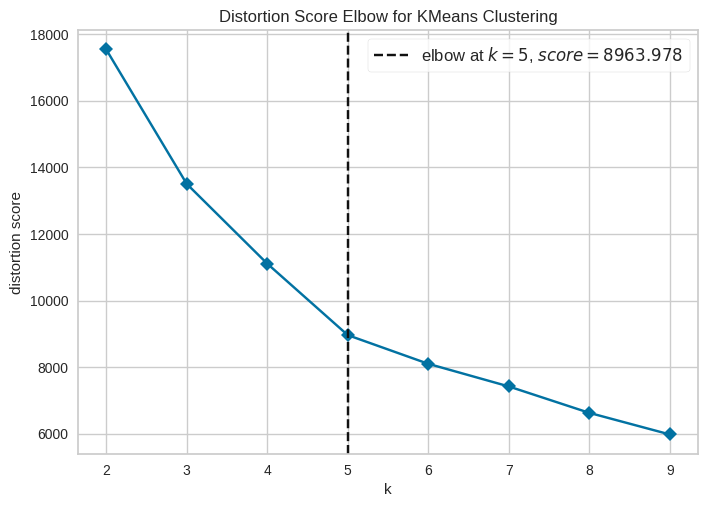

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
# Aplicar Análise do Cotovelo
# o KElbowVisualizer auxilia na seleção do número ideal de clusters para algoritmos de agrupamento, o método do cotovelo é utilizado
# onde a distorção (soma das distâncias quadráticas dos pontos aos centros) é plotada em função do número de clusters (K)
# O ponto onde a curva se achata indica o número ideal de clusters.
final_df_pd = final_df.select("features").toPandas()

features_df = final_df_pd["features"].apply(pd.Series)
scaler = StandardScaler()
df_rfm_clip_scaled = scaler.fit_transform(features_df)

model = KMeans()

model.fit(df_rfm_clip_scaled)

visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)

visualizer.fit(df_rfm_clip_scaled)
visualizer.show()

Calinski-Harabasz Score para K-Means: 2922.591537368291
Silhouette Score para K-Means: 0.37377328707308993


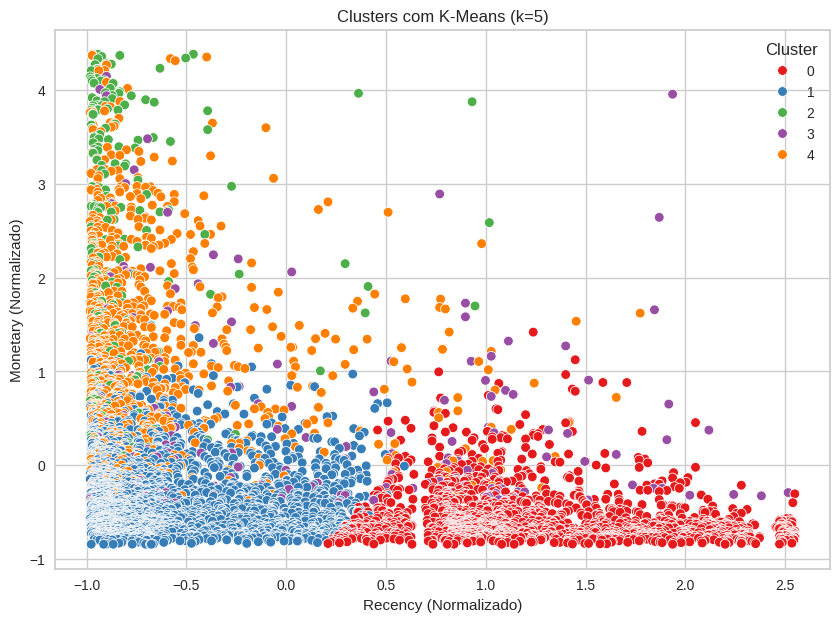

In [12]:
# Definir o número de clusters para Kmeans
k = 5

kmeans = KMeans(n_clusters=k, random_state=1)
model = kmeans.fit(df_rfm_clip_scaled)

clusters_pd = features_df.copy()
clusters_pd['prediction'] = model.labels_

# Calcular Calinski-Harabasz Score
ch_score_kmeans = calinski_harabasz_score(df_rfm_clip_scaled, model.labels_)
print(f'Calinski-Harabasz Score para K-Means: {ch_score_kmeans}')

# Calcular Silhouette Score
silhouette_score_kmeans = silhouette_score(df_rfm_clip_scaled, model.labels_)
print(f'Silhouette Score para K-Means: {silhouette_score_kmeans}')

features_df = pd.DataFrame(df_rfm_clip_scaled, columns=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts"])
features_df['prediction'] = clusters_pd['prediction']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledRecency", y="scaledMonetary", hue="prediction", palette="Set1")
plt.title(f'Clusters com K-Means (k={k})')
plt.xlabel('Recency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()

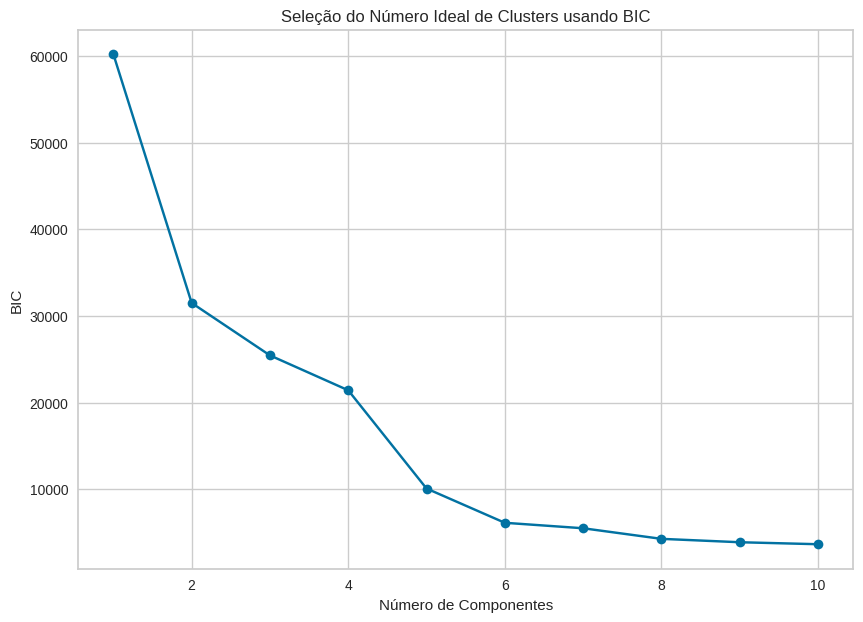

In [13]:
# Aplicar Gaussian Mixture Model
n_components = range(1, 11)
bics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=1)
    gmm.fit(df_rfm_clip_scaled)
    bics.append(gmm.bic(df_rfm_clip_scaled))

plt.figure(figsize=(10, 7))
plt.plot(n_components, bics, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('BIC')
plt.title('Seleção do Número Ideal de Clusters usando BIC')
plt.show()

Calinski-Harabasz Score para K-Means: 2922.591537368291
Silhouette Score para K-Means: 0.37377328707308993


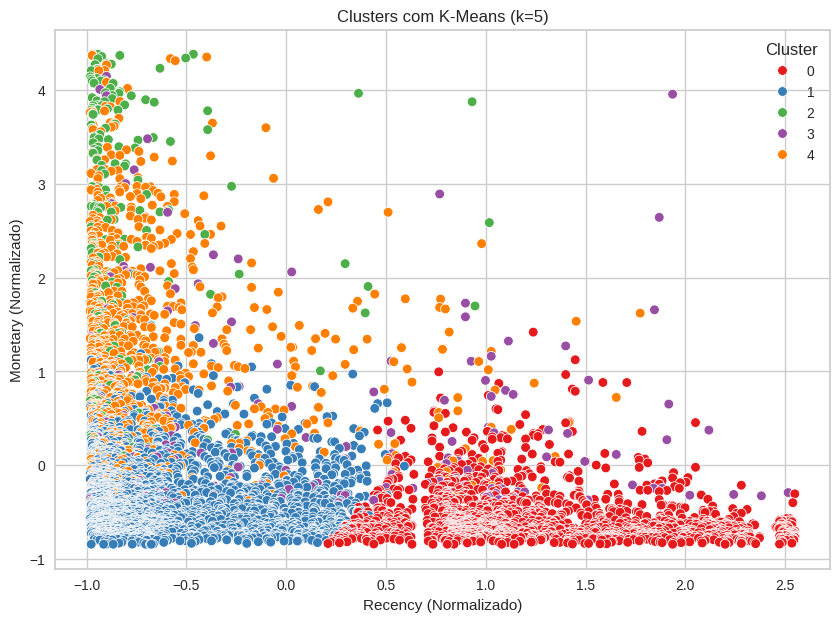

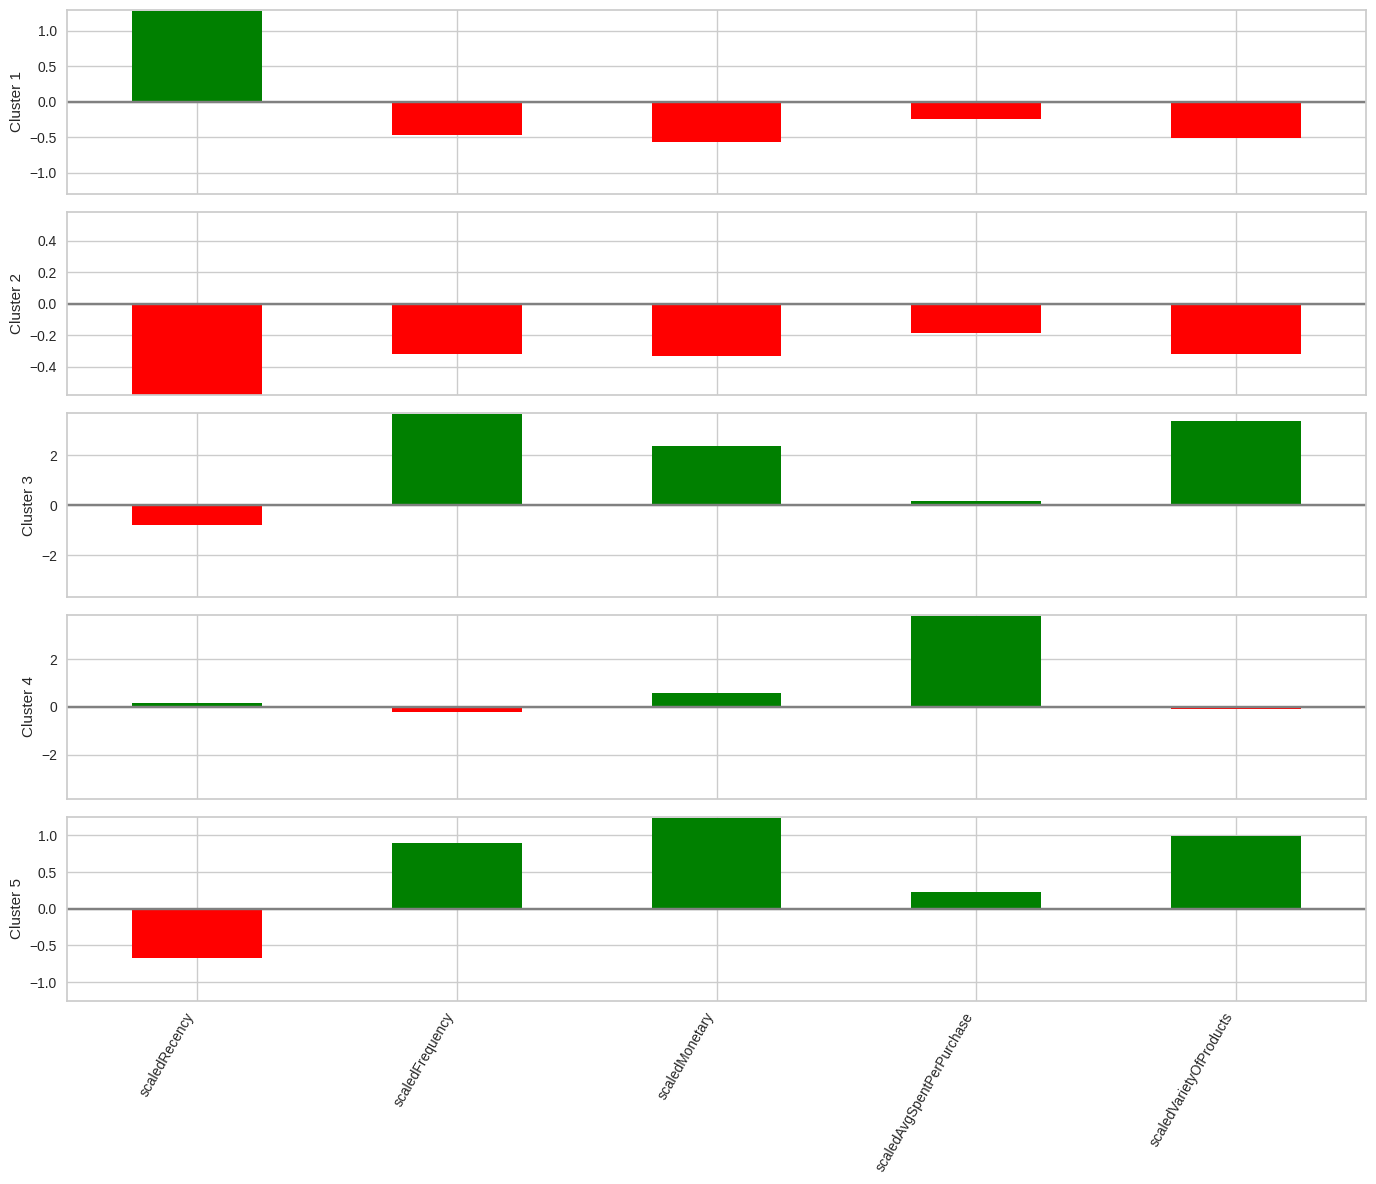

In [14]:
# Definir o número de clusters para Kmeans
k = 5

kmeans = KMeans(n_clusters=k, random_state=1)
model = kmeans.fit(df_rfm_clip_scaled)

clusters_pd = features_df.copy()
clusters_pd['prediction'] = model.labels_

# Calcular Calinski-Harabasz Score
ch_score_kmeans = calinski_harabasz_score(df_rfm_clip_scaled, model.labels_)
print(f'Calinski-Harabasz Score para K-Means: {ch_score_kmeans}')

# Calcular Silhouette Score
silhouette_score_kmeans = silhouette_score(df_rfm_clip_scaled, model.labels_)
print(f'Silhouette Score para K-Means: {silhouette_score_kmeans}')

features_df = pd.DataFrame(df_rfm_clip_scaled, columns=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts"])
features_df['prediction'] = clusters_pd['prediction']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledRecency", y="scaledMonetary", hue="prediction", palette="Set1")
plt.title(f'Clusters com K-Means (k={k})')
plt.xlabel('Recency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()

# Cria um DataFrame com os centros dos clusters do K-Means
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features_df.columns[:-1])

# Adaptado do livro "Practical Statistics for Data Scientists"
fig, axes = plt.subplots(nrows=k, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * center.abs().max()
    colors = ['green' if l > 0 else 'red' for l in center]
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)
    ax.axhline(color='gray')
    ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


## Escolha do modelo

## K-Means vs Gaussian Mixture Model (GMM)

### Resultados das Métricas
#### GMM:

Calinski-Harabasz Score: 1092.76

Silhouette Score: 0.0619

#### K-Means:

Calinski-Harabasz Score: 2930.18

Silhouette Score: 0.3716


## Interpretação
### Calinski-Harabasz Score:
Valores mais altos indicam clusters bem definidos e separados. O K-Means obteve um score significativamente maior.

### Silhouette Score:
Valores mais próximos de 1 indicam melhor agrupamento e separação. O K-Means também apresentou um score muito superior.


##Decisão
Escolhemos o K-Means, pois formou clusters mais compactos e bem definidos, proporcionando uma análise mais precisa e útil para nossos dados.